## Step 0: Installing Libaries

In [15]:
#NS Flash assignment 1

%pip install pandas networkx matplotlib seaborn numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step 1: Load & Clean White Helmets data

In [27]:
df = pd.read_csv('pairwise_52seconds_share.csv')
print(df.head())
print(df.info())

   Unnamed: 0      videoID                  userID_1  \
0           0  -6bGXfM8-gs  19372991|840224732847833   
1          10  -fJbMWhkTAw    Ej8Mm0YMadzmx4osDA_hgg   
2          11  -ilNuSh1Fgw    feNNP607aG1F64jR6bk8jw   
3          12  -ilNuSh1Fgw    5SDVRa-J-_cWYP6g0WNzLw   
4          13  -ilNuSh1Fgw    42Egn_22OjOzg2XMqAa9_g   

                   userID_2          timestamp_1          timestamp_2  \
0  19372991|840224732847833  2018-07-22 21:19:58  2018-07-22 21:19:58   
1    Ej8Mm0YMadzmx4osDA_hgg  2018-08-01 00:51:08  2018-08-01 00:51:08   
2    CVEf5dB1MvNRTQFYivAIPQ  2018-04-27 22:28:49  2018-04-27 22:29:36   
3    jz6hyweGgVHGTw-PbEMqKw  2018-05-14 16:52:08  2018-05-14 16:52:24   
4    poH0yvIGbS5_7MdXM4EuRA  2018-05-14 16:55:04  2018-05-14 16:55:15   

   time_diff_seconds  
0                0.0  
1                0.0  
2               47.0  
3               16.0  
4               11.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns

In [29]:
#Rename column with missing title in csv:
df.rename(columns={'Unnamed: 0': 'edgeID'}, inplace=True)

# Check for missing values
print("\nMissing Values per column")
print(df.isnull().sum())

# Check for duplicate rows
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# --- INVALID VALUES CHECKS ---

# 1. Time difference too large or negative
invalid_time_diff = df[(df['time_diff_seconds'] < 0.0) | (df['time_diff_seconds'] > 52.0)]
print(f"\nRows with invalid time differences: {len(invalid_time_diff)}")

# 2. Self-edges (user connected to itself)
same_user = df[df['userID_1'] == df['userID_2']]
print(f"Rows that connect edge to itself: {len(same_user)}")

# Remove self-edges
df = df[df['userID_1'] != df['userID_2']]
print(f"Remaining rows after removing self-edges: {len(df)}")

# 3. Edges with zero time difference (optional cleanup)
zero_time_diff = df[df['time_diff_seconds'] == 0.0]
print(f"Number of edges where time_diff_seconds is 0.0: {len(zero_time_diff)}")

# Show details for review
if len(zero_time_diff) > 0:
    print(zero_time_diff.head())

# Final dataframe info
print("\nDataFrame info after cleanup:")
print(df.info())



Missing Values per column
edgeID               0
videoID              0
userID_1             0
userID_2             0
timestamp_1          0
timestamp_2          0
time_diff_seconds    0
dtype: int64

Duplicate Rows: 0

Rows with invalid time differences: 0
Rows that connect edge to itself: 344
Remaining rows after removing self-edges: 4127
Number of edges where time_diff_seconds is 0.0: 14
      edgeID      videoID                   userID_1                userID_2  \
161      260  2Jb_lpdNRU8    2572694|885420584986830  3QOONeDucvajwi1U1Y5Z7A   
206      310  3tIupmpY7IA  16548407|1821040977916389  LEb7CblKLJHjHCnmytR5UQ   
482      698  9gXHcOIhB7s     r73dGcK2Gcx8t6UNE1dRHA  GioWuAM9ufsQlV_-1mkHiw   
2501    2731  CLRsB_QJvkI     PMyrVtWQnGWB0QwsKS_NGw  uv3ZAO5Gd5HoRoPdQEywLQ   
3486    3878  OCrY6Q_qZUY    318216|2356029011082368  g6dCJe_oS3-vGq9WrCu6QQ   

              timestamp_1          timestamp_2  time_diff_seconds  
161   2018-08-01 03:00:00  2018-08-01 03:00:00          

## Step 2: Getting to know our data
### Look into #unique_users & #unique_videos

In [82]:
#Get the unique number of users in the dataset
find_unique_users = pd.unique(df[['userID_1', 'userID_2']].values.ravel())
unique_users = len(find_unique_users)
print(unique_users)

#Get the number of unique videos posted
unique_videos = len(df['videoID'].unique())
print(unique_videos)


4030
212


## Step 3: Build graphs for White Helmets data 
### Two graphs: (User <-> User, VideoID <-> User)

Number of Edges in User-User Graph: 4078


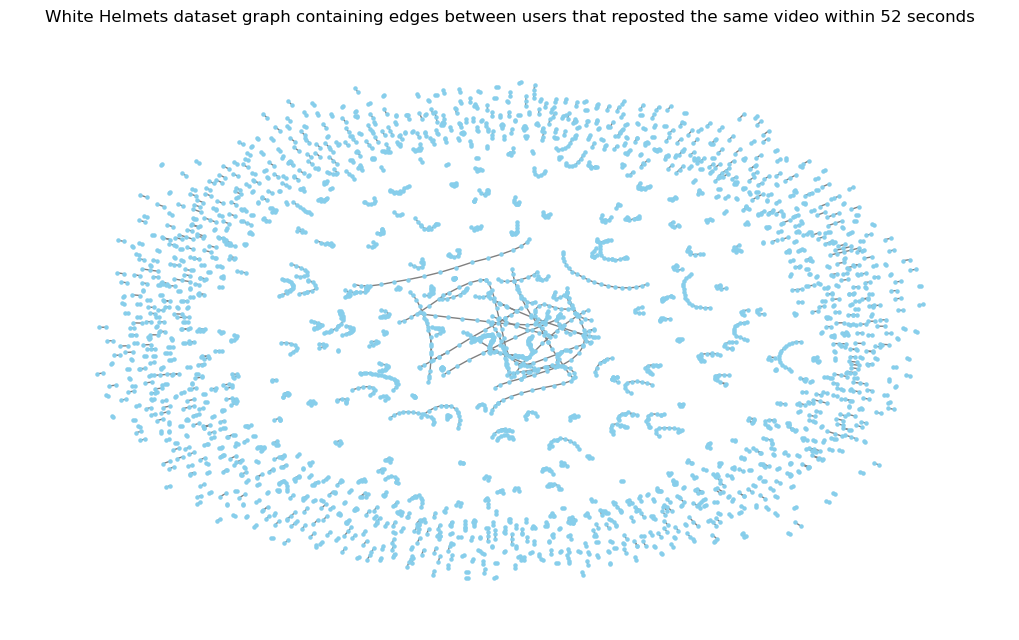

In [119]:
# Build weighted User-User Graph

edge_weights = (
    df.groupby(['userID_1', 'userID_2'])
    .size()
    .reset_index(name='weight')
)

User_graph = nx.from_pandas_edgelist( # Creating an edgelist from the dataframe
    edge_weights,
    source='userID_1', # Undirected network. Edges between users
    target='userID_2',
    edge_attr='weight',
    create_using=nx.Graph()
)

UserGraph_n_edges = User_graph.number_of_edges()
print(f"Number of Edges in User-User Graph:", UserGraph_n_edges)

plt.figure(figsize=(10, 6))
nx.draw(User_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title('White Helmets dataset graph containing edges between users that reposted the same video within 52 seconds')
plt.show()

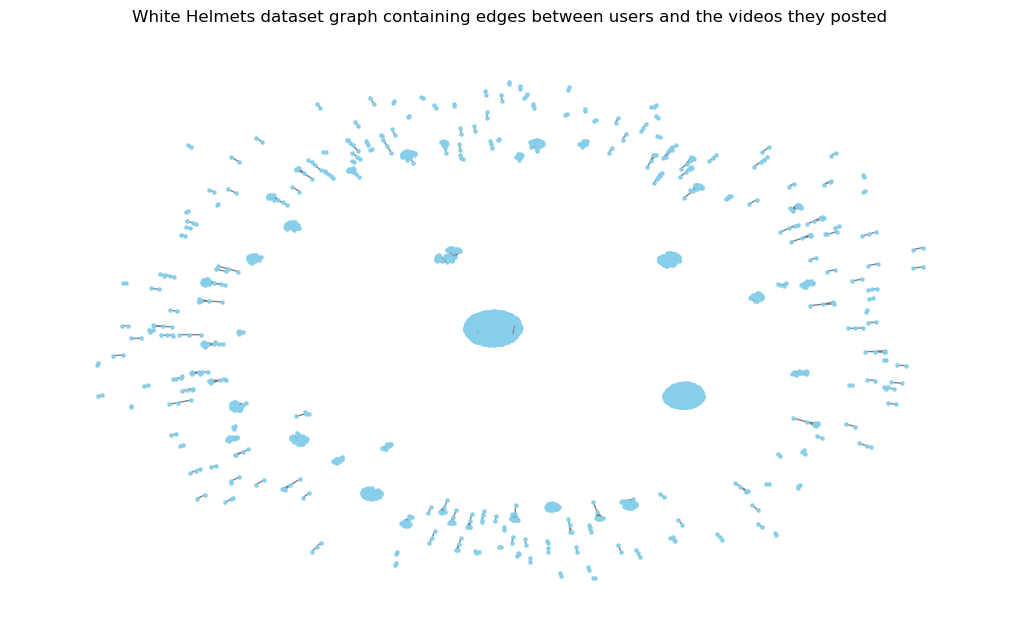

In [38]:
# Build VideoID-User1 Graph
edge_weights = df.groupby(['videoID', 'userID_1']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User1_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_1',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User1_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title('White Helmets dataset graph containing edges between users and the videos they posted')
plt.show()


Is bipartite: True


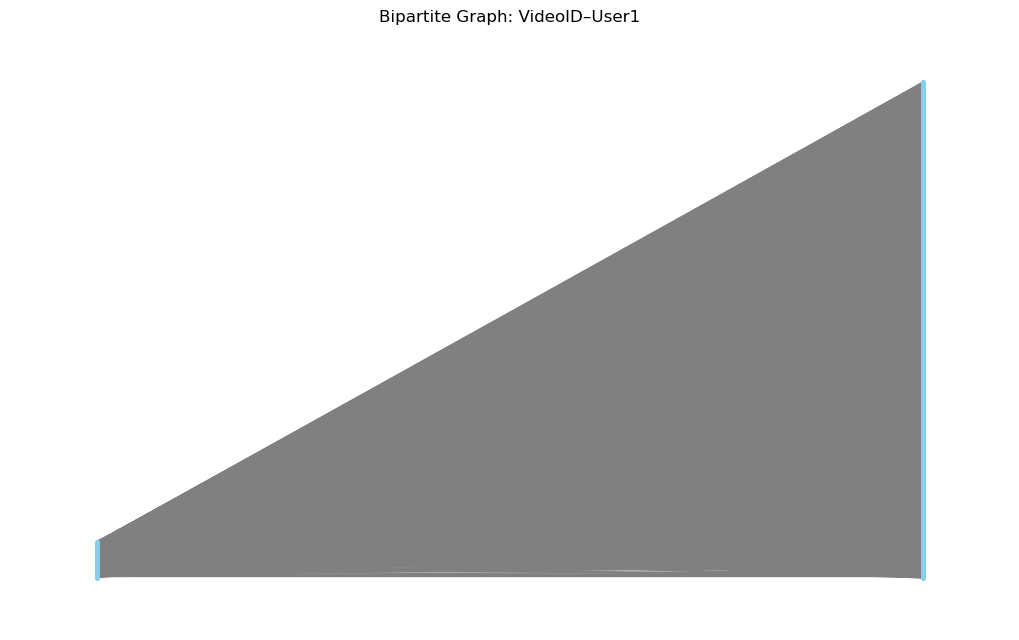

In [48]:
# Build VideoID–User1 Bipartite Graph
edge_weights = df.groupby(['videoID', 'userID_1']).size().reset_index(name='weight')

# Create an empty graph
VideoID_User1_graph = nx.Graph()

# Add nodes for both partitions explicitly
VideoID_User1_graph.add_nodes_from(edge_weights['videoID'], bipartite=0)   # Partition 0: Videos
VideoID_User1_graph.add_nodes_from(edge_weights['userID_1'], bipartite=1)  # Partition 1: Users

# Add weighted edges between the partitions
for _, row in edge_weights.iterrows():
    VideoID_User1_graph.add_edge(row['videoID'], row['userID_1'], weight=row['weight'])

# --- Optional: Verify bipartite structure ---
from networkx.algorithms import bipartite
is_bipartite = bipartite.is_bipartite(VideoID_User1_graph)
print(f"Is bipartite: {is_bipartite}")

# --- Draw bipartite graph ---
# Get the node sets (helps position the two groups separately)
video_nodes = set(n for n, d in VideoID_User1_graph.nodes(data=True) if d['bipartite'] == 0)
user_nodes = set(VideoID_User1_graph) - video_nodes

# Define positions: one group left, one right
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(video_nodes))
pos.update((n, (2, i)) for i, n in enumerate(user_nodes))

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User1_graph, pos=pos, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title("Bipartite Graph: VideoID–User1")
plt.show()


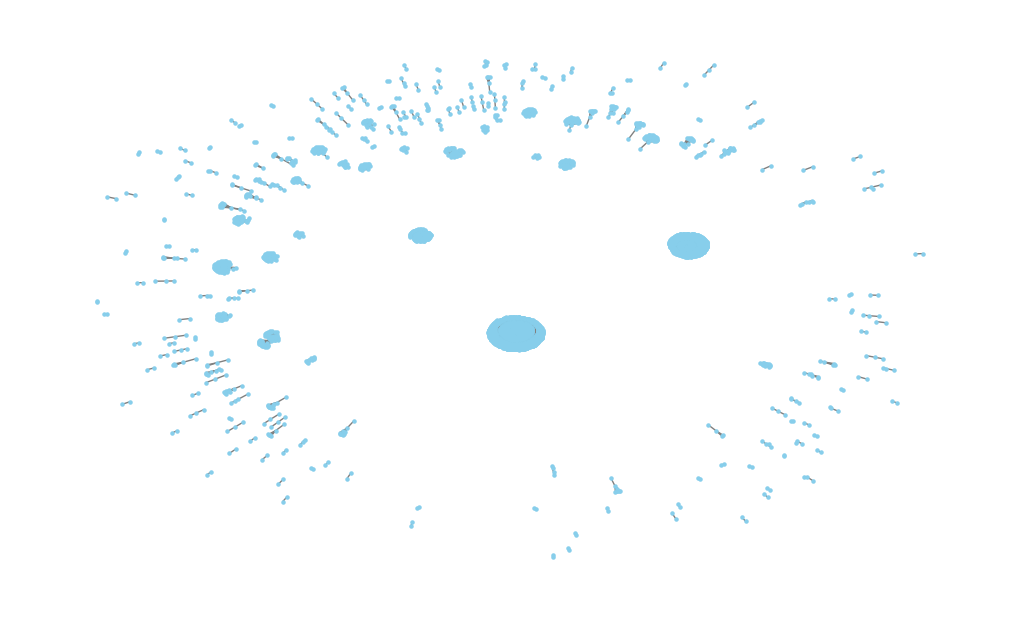

In [50]:
# Build VideoID-User2 Graph
edge_weights = df.groupby(['videoID', 'userID_2']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User2_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_2',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User2_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()


Number of Edges in Video-User Graph: 4091


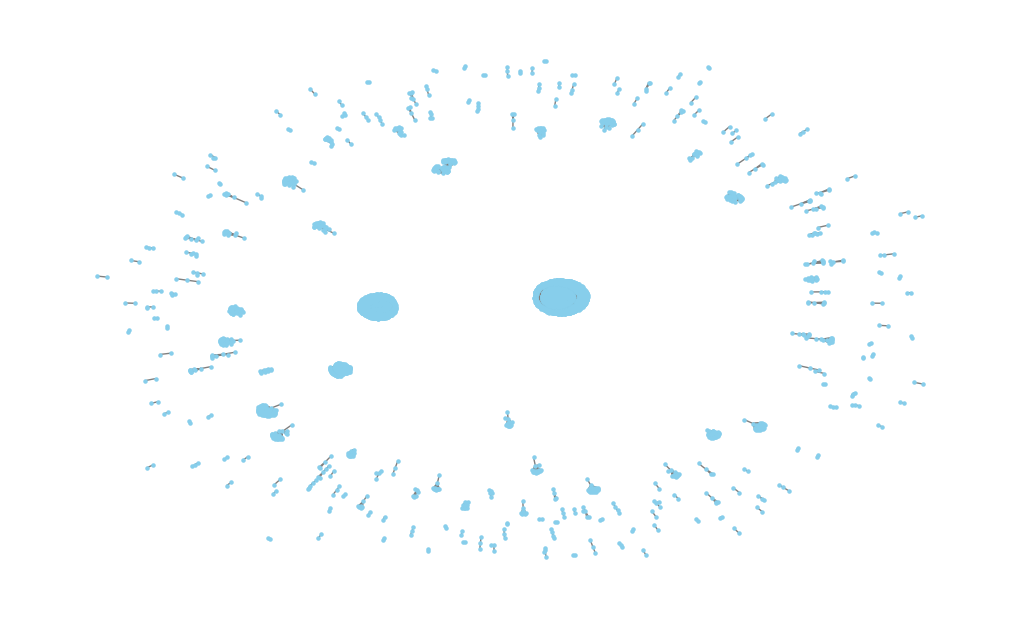

4030
212


In [121]:
#Merge graphs above to get User <-> Video graph:

#Melt the two user columns into one
user_video_pairs = pd.melt(
    df,
    id_vars=['videoID'],
    value_vars=['userID_1', 'userID_2'], #melt these two together
    var_name='user_type', #shows from which column the user came --> maybe we can remove this column as it might just add confusion
    value_name='userID' #name of the melted column
)

#Aggregate weights: shows the #interactions per user-video pair
edge_weights = user_video_pairs.groupby(['videoID', 'userID']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
video_user_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID',
    edge_attr='weight',
    create_using=nx.Graph()
)

UserVideoGraph_n_edges = video_user_graph.number_of_edges()
print(f"Number of Edges in Video-User Graph:", UserVideoGraph_n_edges)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User2_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()

#Check loss of instances (videos or users) --> outputs below give the same number so no loss of instances.
#Get the unique number of users in the dataset
find_unique_users_in_graph = pd.unique(user_video_pairs['userID'])
unique_users_in_UVgraph = len(find_unique_users_in_graph)
print(unique_users_in_UVgraph)

#Get the number of unique videos posted
unique_videos = len(user_video_pairs['videoID'].unique())
print(unique_videos)

Is bipartite: True


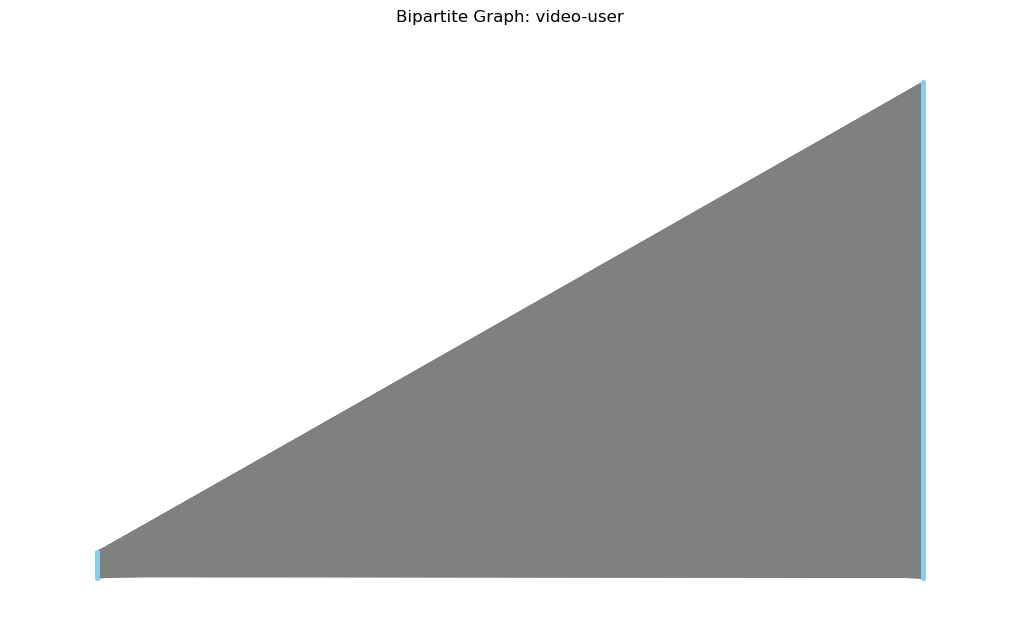

In [98]:
#Create the bipartite graph
video_user_graph = nx.Graph()
video_user_graph.add_nodes_from(edge_weights['videoID'].unique(), bipartite=0)  # videos
video_user_graph.add_nodes_from(edge_weights['userID'].unique(), bipartite=1)  # users

# Add weighted edges
for _, row in edge_weights.iterrows():
    video_user_graph.add_edge(row['userID'], row['videoID'], weight=row['weight'])

from networkx.algorithms import bipartite
is_bipartite = bipartite.is_bipartite(video_user_graph)
print(f"Is bipartite: {is_bipartite}")

# Get the node sets (helps position the two groups separately)
video_nodes = set(n for n, d in VideoID_User1_graph.nodes(data=True) if d['bipartite'] == 0)
user_nodes = set(video_user_graph) - video_nodes

# Define positions: one group left, one right
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(video_nodes))
pos.update((n, (2, i)) for i, n in enumerate(user_nodes))

plt.figure(figsize=(10, 6))
nx.draw(video_user_graph, pos=pos, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title("Bipartite visualization of Video-User")
plt.show()


## Step 4: Get Relevant Network Metrics

#### 1. Density

In [115]:
density_User1 = nx.density(VideoID_User1_graph)
density_User2 = nx.density(VideoID_User2_graph)
density_UserGraph = nx.density(User_graph)
density_UserVideoGraph = nx.density(video_user_graph)

print("Density:")
print(f"VideoID–User1 Graph: {density_User1:.4f}")
print(f"VideoID–User2 Graph: {density_User2:.4f}")
print(f"VideoID–UserID Graph: {density_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {density_UserGraph:.4f}")


Density:
VideoID–User1 Graph: 0.0006
VideoID–User2 Graph: 0.0006
VideoID–UserID Graph: 0.0005
User1–User2 Graph:  0.0005


Justification of metric:
The density measure is normalized between 0 and 1, which allows for easy comparison between different networks. It gives an indicator of how sparse or dense a network is. If the density values of networks differ drastically, the rate of interaction in these networks will probably be very different. In our study, the density metric is not a measure that we will directly compare between the White Helmets dataset and different network models. Rather, we will match the density of our random networks with the density of the White Helmets dataset (0.0005) to ensure that not only the number of nodes but also the number of edges in the networks are similar. This should create a similar amount of interaction between nodes, which - using the other metrics below - allows us to investigate whether the White Helmets dataset is in accordance with the Watts-Strogatz or Barabasi-Albert model (or neither).

### 2. Average Degree

In [111]:
def average_degree(G):
    return sum(dict(G.degree()).values()) / G.number_of_nodes()

avg_degree_User1 = average_degree(VideoID_User1_graph)
avg_degree_User2 = average_degree(VideoID_User2_graph)
avg_degree_UserVideoGraph = average_degree(video_user_graph)
avg_degree_UserGraph = average_degree(User_graph)

print("Average degree:")
print(f"VideoID–User1 Graph: {avg_degree_User1:.4f}")
print(f"VideoID–User2 Graph: {avg_degree_User2:.4f}")
print(f"VideoID–UserID Graph: {avg_degree_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {avg_degree_UserGraph:.4f}")


Average degree:
VideoID–User1 Graph: 1.8905
VideoID–User2 Graph: 1.8905
VideoID–UserID Graph: 1.9288
User1–User2 Graph:  2.0238


Justification of metric: 
The average degree is a good indicator of how many interactions a graph approximately has per node. It might be skewed by hubs, but it is still useful to avoid under- or overestimating the rate of interactions in the network. As we will generate random networks with a similar number of nodes to be able to compare different network models with the White Helmets dataset, the average degree will be a good metric to compare the amount of average node interactions. We will need to thoroughly look at the graphs of our White Helmets dataset to determine whether outliers/hubs skew the results.

### 3. Average Clustering Coefficient

In [46]:
avg_clustering_User1 = nx.average_clustering(VideoID_User1_graph)
avg_clustering_User2 = nx.average_clustering(VideoID_User2_graph)
avg_clustering_UserGraph = nx.average_clustering(User_graph)

print("Average clustering coefficient:")
print(f"VideoID–User1 Graph: {avg_clustering_User1:.4f}")
print(f"VideoID–User2 Graph: {avg_clustering_User2:.4f}")
print(f"User1–User2 Graph:  {avg_clustering_UserGraph:.4f}")


Average clustering coefficient:
VideoID–User1 Graph: 0.0000
VideoID–User2 Graph: 0.0000
User1–User2 Graph:  0.2998


Justification of metric:

### 4. Average Betweenness Centrality

In [49]:
bet_cent_User1 = nx.betweenness_centrality(VideoID_User1_graph)
bet_cent_User2 = nx.betweenness_centrality(VideoID_User2_graph)
bet_cent_UserGraph = nx.betweenness_centrality(User_graph)

avg_betweenness_User1 = sum(bet_cent_User1.values()) / len(bet_cent_User1)
avg_betweenness_User2 = sum(bet_cent_User2.values()) / len(bet_cent_User2)
avg_betweenness_UserGraph = sum(bet_cent_UserGraph.values()) / len(bet_cent_UserGraph)

print("Average betweenness centrality:")
print(f"VideoID–User1 Graph: {avg_betweenness_User1:.7f}")
print(f"VideoID–User2 Graph: {avg_betweenness_User2:.7f}")
print(f"User1–User2 Graph:  {avg_betweenness_UserGraph:.7f}")


Average betweenness centrality:
VideoID–User1 Graph: 0.0000683
VideoID–User2 Graph: 0.0000683
User1–User2 Graph:  0.0000014


Justification of metric: 
Average Betweeness Centrality shows the importance of individual nodes in the network. It gives an idea of how centralized a network is. It is suitable for the task to understand if there are indivudal nodes which are important and central for the spread of information.

### 5. Average Degree Centrality

In [50]:
deg_cent_User1 = nx.degree_centrality(VideoID_User1_graph)
deg_cent_User2 = nx.degree_centrality(VideoID_User2_graph)
deg_cent_UserGraph = nx.degree_centrality(User_graph)

avg_deg_cent_User1 = sum(deg_cent_User1.values()) / len(deg_cent_User1)
avg_deg_cent_User2 = sum(deg_cent_User2.values()) / len(deg_cent_User2)
avg_deg_cent_UserGraph = sum(deg_cent_UserGraph.values()) / len(deg_cent_UserGraph)

print("Average degree centrality:")
print(f"VideoID–User1 Graph: {avg_deg_cent_User1:.6f}")
print(f"VideoID–User2 Graph: {avg_deg_cent_User2:.6f}")
print(f"User1–User2 Graph:  {avg_deg_cent_UserGraph:.6f}")


Average degree centrality:
VideoID–User1 Graph: 0.000613
VideoID–User2 Graph: 0.000613
User1–User2 Graph:  0.000502


Justification of metric:

### 6. Average Shortest Path Length

In [51]:
def avg_shortest_path(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        largest_component = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_component)
        return nx.average_shortest_path_length(subgraph)

avg_path_User1 = avg_shortest_path(VideoID_User1_graph)
avg_path_User2 = avg_shortest_path(VideoID_User2_graph)
avg_path_UserGraph = avg_shortest_path(User_graph)

print("Average shortest path length (LCC):")
print(f"VideoID–User1 Graph: {avg_path_User1:.4f}")
print(f"VideoID–User2 Graph: {avg_path_User2:.4f}")
print(f"User1–User2 Graph:  {avg_path_UserGraph:.4f}")


Average shortest path length (LCC):
VideoID–User1 Graph: 1.9985
VideoID–User2 Graph: 1.9985
User1–User2 Graph:  8.9026


Justification of metric:
The average shortest path length is good way to see how fast information can spread. Especially in the case of the White Helmet data set it is crucial to see how fast users can spread videos and therefore information to reach their goal. A shorter average shortest path indicates that information reaches the people very quickly and makes the network possibly very important.

### Step 5: Construct Watts Stogratz Graph

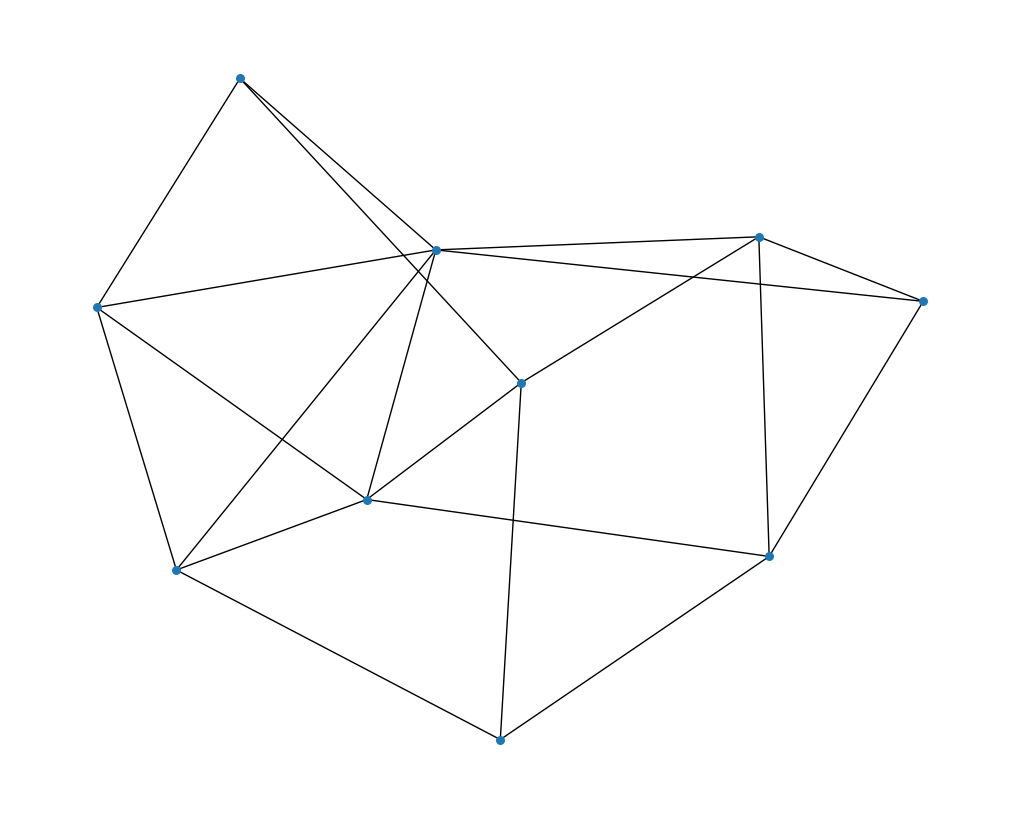

In [60]:
WS  = nx.watts_strogatz_graph(10, k=4, p=0.9, seed=None, create_using=None)
plt.figure(figsize=(10, 8))
nx.draw(WS, with_labels=False, node_size=30)
plt.show()

Justification of model: Watts Strogatz Graphs make it possible to generate graph with the same amount of nodes and a similar average degree compared to the White Helmet data set. These to attributes are very fundamental to a network and determine a lot of the shape of a network. Furthermore Watts Strogatz Graphs can recreate high clustering as it is seen in part of the White Helmet data set. Through the probability parameter the randomness of the network can be controlled. That makes this kind of graph very suitable to compare it against a real network to see if there are any inorganic patterns to be discovered.

### Step 6: Construct Barabási-Albert Graph

### Step 7: Evaluation of the results

### 1. Density

### 2. Average degree